In [1]:
# WELFake Fake News Detection Model

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import re
import time
from lime.lime_text import LimeTextExplainer
from sklearn.model_selection import train_test_split

In [2]:
# function to perform minimal text preprocessing for transformer models
# arguments:
# text - input text to preprocess (string)
# max_length - maximum number of words to keep (default: 512)
#
# returns preprocessed text string
def preprocess_text(text, max_length=512):
    # step 1: handle edge cases
    if not isinstance(text, str):
        return ""
    
    # step 2: clean encoding issues
    # remove non-ascii characters that could cause problems
    text = text.encode('ascii', 'ignore').decode('ascii')
    
    # step 3: normalize text format
    # replace multiple whitespace characters with single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    # step 4: truncate oversized inputs
    # transformer models have context length limits
    words = text.split()
    if len(words) > max_length:
        text = ' '.join(words[:max_length])
        
    return text

In [3]:
# function to load and preprocess WELFake dataset
# arguments:
# welfake_path - path to WELFake_Dataset.csv
# return - tuple of (train_df, valid_df, test_df) with preprocessed data
def load_welfake_dataset(welfake_path="data/welfake_dataset/WELFake_Dataset.csv"):
    # step 1: load the raw dataset
    print(f"Loading WELFake dataset from {welfake_path}...")
    welfake_df = pd.read_csv(welfake_path)

    # step 2: rename/reshape columns
    welfake_df['statement'] = welfake_df['title'] + " " + welfake_df['text'].fillna("")
    welfake_df['label'] = welfake_df['label']  # Already binary (1=real, 0=fake)
    
    # step 3: keep only needed columns
    welfake_df = welfake_df[['statement', 'label']]
    
    # step 4: apply preprocessing
    print("Applying text preprocessing...")
    welfake_df['statement'] = welfake_df['statement'].apply(preprocess_text)

    # step 5: do train/valid/test split
    train_df, temp_df = train_test_split(welfake_df, test_size=0.2, random_state=42)
    valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    
    # step 6: print dataset statistics
    print(f"WELFake dataset statistics:")
    print(f"  Total: {len(welfake_df)} samples")
    print(f"  Train: {len(train_df)} samples")
    print(f"  Valid: {len(valid_df)} samples")
    print(f"  Test: {len(test_df)} samples")
    
    # step 7: check class balance
    print(f"\nClass distribution:")
    print(f"  Overall: {welfake_df['label'].value_counts().to_dict()}")
    print(f"  Train: {train_df['label'].value_counts().to_dict()}")
    print(f"  Valid: {valid_df['label'].value_counts().to_dict()}")
    print(f"  Test: {test_df['label'].value_counts().to_dict()}")

    return train_df, valid_df, test_df

In [4]:
# dataset class for WELFake fake news detection
class FakeNewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        # step 1: store dataframe and extract necessary columns
        self.df = df
        self.texts = df['statement'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # step 1: get text and label for the index
        text = self.texts[idx]
        label = self.labels[idx]
        
        # step 2: tokenize the text
        encodings = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # step 3: return the encodings and label
        return {
            'input_ids': encodings['input_ids'].squeeze(),
            'attention_mask': encodings['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [5]:
# compute metrics for model evaluation
# arguments:
# eval_pred - tuple of (predictions, labels)
# return - dictionary with evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, zero_division=0),
        'recall': recall_score(labels, predictions),
        'f1': f1_score(labels, predictions),
        'roc_auc': roc_auc_score(labels, predictions) if len(np.unique(labels)) > 1 else 0
    }

In [6]:
# function to perform hyperparameter tuning using Bayesian optimization
# arguments:
# model_name - pretrained model name to use
# train_dataset - dataset for model training
# valid_dataset - dataset for validation during tuning
# n_trials - number of hyperparameter combinations to try (default: 20)
#
# returns dictionary with best hyperparameter combination
def tune_hyperparameters(model_name, train_dataset, valid_dataset, n_trials):
    # step 1: prepare storage directory
    base_dir = "./welfake_hp_tuning_optuna"
    os.makedirs(base_dir, exist_ok=True)
    
    # step 2: define objective function for optimization
    def objective(trial):
        # step 2.1: sample hyperparameter values
        lr = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
        weight_decay = trial.suggest_float("weight_decay", 0.01, 0.2, log=True)
        batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
        epochs = trial.suggest_int("epochs", 2, 3)
        gradient_accumulation_steps = trial.suggest_categorical("gradient_accumulation_steps", [1, 2, 4]) # new (v2.5 step2)
        
        # step 2.2: create directory for this trial's outputs
        trial_dir = f"{base_dir}/trial_{trial.number}"
        os.makedirs(trial_dir, exist_ok=True)
        
        # step 2.3: check for existing checkpoint
        checkpoint_path = f"{trial_dir}/checkpoint.pt"
        start_epoch = 0  # default starting point
        
        # step 2.4: configure training parameters
        training_args = TrainingArguments(
            output_dir=trial_dir,
            eval_strategy="epoch",
            save_strategy="epoch",
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=epochs,
            weight_decay=weight_decay,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            push_to_hub=False,
            report_to="none",
            logging_steps=500,
            disable_tqdm=False,
            save_total_limit=1,  # keep only best checkpoint
            gradient_accumulation_steps=gradient_accumulation_steps
        )
        
        # step 2.5: initialize model and trainer
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=2
        )
        
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=valid_dataset,
            compute_metrics=compute_metrics
        )
        
        # step 2.7: attempt to resume from checkpoint if available
        if os.path.exists(checkpoint_path):
            print(f"Resuming from checkpoint for trial {trial.number}")
            checkpoint_state = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint_state['model_state_dict'])
            start_epoch = checkpoint_state['epoch']
            
            # if already completed, just return saved result
            if start_epoch >= epochs:
                return checkpoint_state['f1_score']
        
        # step 2.8: train model if not already completed
        if start_epoch < epochs:
            try:
                # perform training
                trainer.train()
                
                # compute performance metrics
                eval_result = trainer.evaluate()
                f1_score = eval_result["eval_f1"]
                
                # save checkpoint for possible resumption
                torch.save({
                    'epoch': epochs,
                    'model_state_dict': model.state_dict(),
                    'f1_score': f1_score
                }, checkpoint_path)
                
                # report result to Optuna
                trial.report(f1_score, epochs - 1)
                
                print(f"  Trial {trial.number} - F1 Score: {f1_score:.4f}")
                return f1_score
                
            except Exception as e:
                # handle training failures by saving state
                if start_epoch > 0:
                    torch.save({
                        'epoch': start_epoch,
                        'model_state_dict': model.state_dict(),
                        'f1_score': 0  # default for failed runs
                    }, checkpoint_path)
                print(f"Training failed: {e}")
                return 0
    
    # step 3: create and configure the Optuna study
    study = optuna.create_study(
        direction="maximize",  # maximize F1 score
        sampler=TPESampler(seed=42),  # use Tree-structured Parzen Estimator
        pruner=MedianPruner(n_startup_trials=1, n_warmup_steps=1),  # prune unpromising trials
        study_name="welfake_fake_news_detection",
        storage=f"sqlite:///{base_dir}/optuna_study.db",  # persistent storage
        load_if_exists=True  # resume existing study if available
    )
    
    # step 4: run optimization process
    study.optimize(objective, n_trials=n_trials)
    
    # step 5: extract and display results
    best_params = study.best_params
    best_f1 = study.best_value
    
    # step 5.1: print summary information
    print("\nOptuna hyperparameter tuning complete!")
    print(f"Best F1 score: {best_f1:.4f}")
    print(f"Best parameters: {best_params}")
    
    # step 5.2: show parameter importance if possible
    try:
        importance = optuna.importance.get_param_importances(study)
        print("\nHyperparameter importance:")
        for param, score in importance.items():
            print(f"  {param}: {score:.4f}")
    except:
        print("Could not calculate hyperparameter importance (requires at least 2 completed trials)")
    
    # step 5.3: show top performing configurations
    print("\nTop 5 trials:")
    sorted_trials = sorted(study.trials, key=lambda t: t.value if t.value is not None else -1, reverse=True)
    for i, trial in enumerate(sorted_trials[:5]):
        if trial.value is not None:
            print(f"Rank {i+1}: F1={trial.value:.4f}, Params={trial.params}")
    
    return best_params

In [7]:
# function to evaluate model performance
# arguments:
# trainer - Trainer instance
# test_dataset - dataset to evaluate on
# return - dictionary with evaluation metrics
def evaluate_model(trainer, test_dataset):
    # step 1: get overall metrics using trainer
    test_results = trainer.evaluate(test_dataset)
    
    # step 2: get predictions for more detailed analysis
    test_predictions = trainer.predict(test_dataset)
    predictions = np.argmax(test_predictions.predictions, axis=1)
    true_labels = test_predictions.label_ids
    
    # step 3: convert results to a more readable format
    readable_results = {}
    for key, value in test_results.items():
        # Extract the actual metric name from keys like 'eval_accuracy'
        if key.startswith('eval_'):
            metric_name = key[5:]  # Remove 'eval_' prefix
            readable_results[metric_name] = round(value, 4)  # Round to 4 decimal places
        else:
            readable_results[key] = value
    
    # step 4: display overall metrics table
    overall_metrics = pd.DataFrame({
        'Metric': list(readable_results.keys()),
        'Value': list(readable_results.values())
    })
    print("\nPerformance Metrics:")
    print(overall_metrics.set_index('Metric').transpose())
    
    # step 5: create confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"]).plot(cmap="Blues")
    plt.title("WELFake Fake News Detection Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    # step 6: class-wise performance analysis
    class_names = ["Fake (0)", "Real (1)"]
    for i, class_name in enumerate(class_names):
        class_indices = [idx for idx, label in enumerate(true_labels) if label == i]
        if len(class_indices) > 0:
            class_true = [true_labels[idx] for idx in class_indices]
            class_pred = [predictions[idx] for idx in class_indices]
            
            class_accuracy = accuracy_score(class_true, class_pred)
            print(f"\n{class_name} class performance:")
            print(f"  Samples: {len(class_indices)}")
            print(f"  Accuracy: {class_accuracy:.4f}")
    
    return readable_results

In [8]:
# main function to run the WELFake fake news detection pipeline
def run_welfake_pipeline(welfake_path="data/welfake_dataset/WELFake_Dataset.csv", n_trials=1):
    # step 1: load dataset
    train_df, valid_df, test_df = load_welfake_dataset(welfake_path)
    
    # step 2: initialize tokenizer
    model_name = "distilbert-base-uncased"
    print(f"\nInitializing tokenizer for {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # step 3: create datasets
    print("Creating PyTorch datasets...")
    train_dataset = FakeNewsDataset(train_df, tokenizer)
    valid_dataset = FakeNewsDataset(valid_df, tokenizer)
    test_dataset = FakeNewsDataset(test_df, tokenizer)
    
    # step 4: perform hyperparameter tuning with Optuna
    print("\nStarting hyperparameter tuning...")
    best_hparams = tune_hyperparameters(
        model_name, 
        train_dataset, 
        valid_dataset,
        n_trials=n_trials
    )
    
    # step 5: train final model with optimal hyperparameters
    print("\nTraining final model with optimal hyperparameters...")
    
    # configure training with optimal hyperparameters
    training_args = TrainingArguments(
        output_dir="./welfake_testModel",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=best_hparams["learning_rate"],
        per_device_train_batch_size=best_hparams["batch_size"],
        per_device_eval_batch_size=best_hparams["batch_size"],
        num_train_epochs=best_hparams["epochs"],
        weight_decay=best_hparams["weight_decay"],
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        push_to_hub=False,
        report_to="none",
        gradient_accumulation_steps=best_hparams.get("gradient_accumulation_steps", 1)
    )
    
    # initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=2
    )
    
    # set up early stopping
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=2,
        early_stopping_threshold=0.001
    )
    
    # initialize Trainer for final training
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback]
    )
    
    # train the model
    trainer.train()
    
    # step 6: evaluate model
    print("\nEvaluating final model...")
    evaluation_metrics = evaluate_model(trainer, test_dataset)
    
    # step 7: save model
    model_path = "welfake_only_test"
    trainer.save_model(model_path)
    tokenizer.save_pretrained(model_path)
    print(f"\nModel and tokenizer saved to {model_path}")
    
    return trainer, evaluation_metrics, best_hparams

Loading WELFake dataset from data/welfake_dataset/WELFake_Dataset.csv...
Applying text preprocessing...
WELFake dataset statistics:
  Total: 72134 samples
  Train: 57707 samples
  Valid: 7213 samples
  Test: 7214 samples

Class distribution:
  Overall: {1: 37106, 0: 35028}
  Train: {1: 29768, 0: 27939}
  Valid: {1: 3667, 0: 3546}
  Test: {1: 3671, 0: 3543}

Initializing tokenizer for distilbert-base-uncased...
Creating PyTorch datasets...

Starting hyperparameter tuning...


[I 2025-03-26 07:14:51,053] A new study created in RDB with name: welfake_fake_news_detection
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.038600,0.048767,0.987245,0.979351,0.995909,0.987561,0.987097
2,0.013000,0.038385,0.991266,0.992350,0.990455,0.991402,0.991280


[I 2025-03-26 07:32:47,378] Trial 0 finished with value: 0.9914016650743824 and parameters: {'learning_rate': 1.827226177606625e-05, 'weight_decay': 0.17254716573280354, 'batch_size': 8, 'epochs': 2, 'gradient_accumulation_steps': 2}. Best is trial 0 with value: 0.9914016650743824.


  Trial 0 - F1 Score: 0.9914

Optuna hyperparameter tuning complete!
Best F1 score: 0.9914
Best parameters: {'learning_rate': 1.827226177606625e-05, 'weight_decay': 0.17254716573280354, 'batch_size': 8, 'epochs': 2, 'gradient_accumulation_steps': 2}
Could not calculate hyperparameter importance (requires at least 2 completed trials)

Top 5 trials:
Rank 1: F1=0.9914, Params={'learning_rate': 1.827226177606625e-05, 'weight_decay': 0.17254716573280354, 'batch_size': 8, 'epochs': 2, 'gradient_accumulation_steps': 2}

Training final model with optimal hyperparameters...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.041300,0.046740,0.987661,0.980140,0.995909,0.987962,0.987520
2,0.009700,0.038012,0.991820,0.992896,0.991001,0.991948,0.991834



Evaluating final model...



Performance Metrics:
Metric    loss  accuracy  precision  recall      f1  roc_auc  runtime  \
Value   0.0379    0.9915     0.9959  0.9875  0.9917   0.9916  21.7842   

Metric  samples_per_second  steps_per_second  epoch  
Value              331.158            41.406    2.0  


<Figure size 800x600 with 0 Axes>

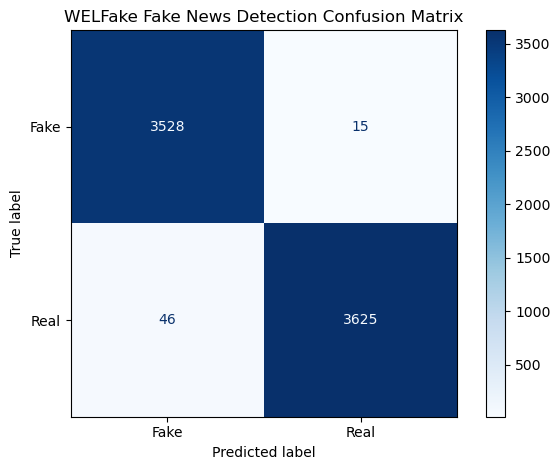


Fake (0) class performance:
  Samples: 3543
  Accuracy: 0.9958

Real (1) class performance:
  Samples: 3671
  Accuracy: 0.9875

Model and tokenizer saved to welfake_only_test


In [9]:
# run the pipeline 
if __name__ == "__main__":
    # Train and evaluate the model
    trainer, metrics, best_hparams = run_welfake_pipeline()
    
    # Optionally run the interactive interface
    # Uncomment the line below to run the interface after training
    # run_interactive_text_interface()